2022.08.29   
DACON AI 양재허브 인공지능 오픈소스 경진대회   
Image Super-Resolution // PSNR

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import cv2
import os
from tqdm.auto import tqdm
import PIL



Device 확인

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
torch.cuda.empty_cache()

import gc
gc.collect()

cuda


0

# CustomDataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, transform=None, train_mode=True):
        self.transform = transform
        self.train_mode = train_mode

        self.low_list = img_list['LR']
        if self.train_mode:
            self.high_list = img_list['HR']

    def __getitem__(self,index):
        low_path = './data/'+self.low_list.iloc[index][1:]
        low_img = PIL.Image.open(low_path)
        
        if self.transform is not None:
            low_img=self.transform(low_img)
        
        if self.train_mode:
            high_path = './data/'+self.high_list.iloc[index][1:]
            high_img = PIL.Image.open(high_path)
            if self.transform is not None:
                high_img = self.transform(high_img)
            return low_img, high_img
        else:
            file_name = low_path.split('/')[-1]
                
            return low_img, file_name
    
    def __len__(self):
        return len(self.low_list)


In [4]:
csv_path = os.getcwd()+'/data/train.csv'
df = pd.read_csv(csv_path)
print(df[:3])

                    LR                   HR
0  ./train/lr/0000.png  ./train/hr/0000.png
1  ./train/lr/0001.png  ./train/hr/0001.png
2  ./train/lr/0002.png  ./train/hr/0002.png


CustomDataset 확인하기

(512, 512)


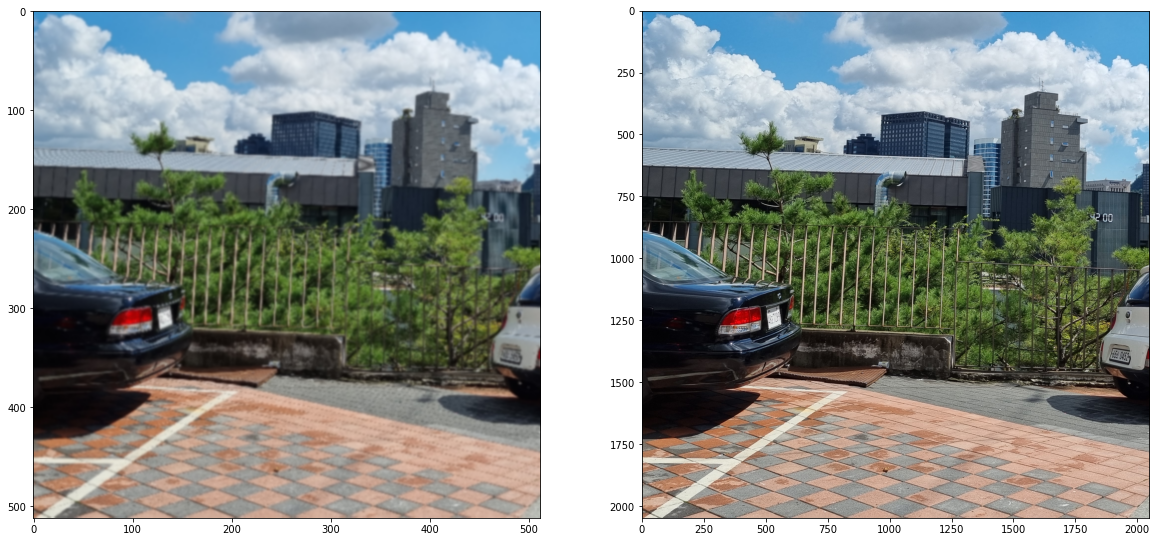

In [5]:
import matplotlib.pyplot as plt
temp_path = os.getcwd()+'/data/train.csv'
temp_list = pd.read_csv(temp_path)

temp_dataset = CustomDataset(temp_list,transform=None,train_mode=True)
low, high = temp_dataset.__getitem__(0)
print(low.size)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(low)

plt.subplot(1,2,2)
plt.imshow(high)


In [6]:
BATCH_SIZE =4
IMG_SIZE=2048

# Transform

In [7]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([IMG_SIZE,IMG_SIZE]),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([IMG_SIZE,IMG_SIZE]),
    torchvision.transforms.ToTensor(),
])

In [8]:
train_path = os.getcwd()+'/data/train.csv'
train_list = pd.read_csv(train_path)
train_list = train_list[0:int(len(train_list)*0.75)]
val_list = train_list[int(len(train_list)*0.75):]

train_dataset = CustomDataset(train_list,train_transform,train_mode=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

val_dataset = CustomDataset(val_list,test_transform,train_mode=True)
val_loader = torch.utils.data.DataLoader(val_dataset,BATCH_SIZE,False)


test_path = os.getcwd()+'/data/test.csv'
test_list = pd.read_csv(test_path)
test_dataset = CustomDataset(test_list,test_transform,train_mode=False)
test_loader = DataLoader(test_dataset,BATCH_SIZE,False)


# Model

In [9]:
class SRCNN(torch.nn.Module):
    def __init__(self, channels=3, feature_dim = 64, map_dim=32):
        super(SRCNN, self).__init__()
        self.features =torch.nn.Sequential(
            torch.nn.Conv2d(channels, feature_dim,kernel_size=9,stride=1,padding=4,bias=True),
            torch.nn.ReLU(True)
        )

        self.map = torch.nn.Sequential(
            torch.nn.Conv2d(feature_dim,map_dim,5,1,2,bias=True),
            torch.nn.ReLU(True)
        )
        self.reconstruction = torch.nn.Conv2d(map_dim,channels,5,1,2)
        self._initial_weights()

    def forward(self,x):
        features = self.features(x)
        maps = self.map(features)
        out = self.reconstruction(maps)
        return out
    def _initial_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                torch.nn.init.zeros_(m.bias.data)
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)


# Train Code

In [10]:
def train(train_loader,val_loader, model, epochs,criterion, optimizer, scheduler=None, device='cpu'):
    model.to(device)
    best_loss = 9999
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    count = 0
    for epoch in range(1,epochs+1):
        model.train()
        running_loss =0.0

        for data in tqdm(iter(train_loader)):
            lr_img = data[0].to(device)
            hr_img = data[1].to(device)

            optimizer.zero_grad()

            outputs = model(lr_img)
            loss = criterion(outputs,hr_img)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if scheduler is not None:
            scheduler.step()
        
        # val
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in tqdm(iter(val_loader)):
                ir_img = data[0].to(device)
                hr_img = data[1].to(device)

                outputs = model(ir_img)
                loss = criterion(outputs,hr_img)

                val_loss +=loss.item()
        print(f'{epoch} Train Loss : {running_loss:.5f}')
        print(f'val_loss : {val_loss:.5f}')
        
        # early stopping 
        if best_loss <= val_loss:
            count +=1
            if count >4:
                print('Early Stopping')
                break
        else:
            torch.save(model.state_dict(),f'checkpoint/best_SRCNN.pth')
            print('Model Saved')
            best_loss = val_loss
            count = 1

        history['train_loss'].append(running_loss)
        history['val_loss'].append(val_loss)
    return history

In [11]:
model = SRCNN()
optimizer = torch.optim.Adam(params=model.parameters(), lr =0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size= 10,gamma=0.3)
criterion = torch.nn.MSELoss()

In [12]:
history = train(train_loader,val_loader, model, 200, criterion,optimizer,scheduler,device)

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

1 Train Loss : 122.83960
val_loss : 6.23714
Model Saved


KeyError: 'train_loss'

# Submission

In [14]:
def inference(model, test_loader ,device):
    model.to(device)
    model.eval()
    pred_img_list = []
    name_list = []
    with torch.no_grad():
        for lr_img, file_name in tqdm(iter(test_loader)):
            lr_img = lr_img.float().to(device)

            pred_img = model(lr_img)

            for pred, name in zip(pred_img,file_name):
                pred = pred.cpu().clone().detach().numpy()
                pred = pred.transpose(1,2,0)
                pred = pred*255

                pred_img_list.append(pred.astype('uint8'))
                name_list.append(name)
    return pred_img_list,name_list


In [15]:
checkpoint = torch.load('checkpoint/best_SRCNN.pth')
model.load_state_dict(checkpoint, strict=False)

pred_img_list, pred_name_list = inference(model, test_loader,device)

  0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
import zipfile
os.chdir('/workspace/Torch/dacon/ISR/data/submission/')
# os.chdir('./data/submission/')
sub_imgs = []
for path, pred_img in tqdm(zip(pred_name_list,pred_img_list)):
    cv2.imwrite(path,pred_img)
    sub_imgs.append(path)

submission = zipfile.ZipFile('../submission.zip','w')
for path in sub_imgs:
    submission.write(path)
submission.close()
print('Done')

0it [00:00, ?it/s]

Done
